<a href="https://colab.research.google.com/github/mohabxxx/BCPS/blob/main/MohabFaresModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import cv2
import os
import glob
import skimage
import numpy as np
import pandas as pd
import seaborn as sn
import preprocessing
from tqdm import tqdm
from io import BytesIO
from PIL import Image
from os import listdir
import matplotlib.pyplot as plt
from imageio import imread
from skimage.transform import resize
from collections import Counter
import IPython.display as display

sn.set()

from sklearn.svm import SVC # SVC
from sklearn import metrics
from sklearn.utils import shuffle
from xgboost import XGBClassifier # XGBClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils import compute_class_weight
from sklearn.preprocessing import MinMaxScaler,LabelBinarizer
from sklearn.ensemble import AdaBoostClassifier # AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier # KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier # RandomForestClassifier
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.metrics import AUC
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.applications.vgg16 import VGG16 # VGG16
from tensorflow.keras.applications.vgg19 import VGG19 # VGG19
from tensorflow.keras.applications.resnet50 import ResNet50 # ResNet50
from tensorflow.keras.applications.xception import Xception # Xception
from tensorflow.keras.applications.mobilenet import MobileNet # MobileNet
from tensorflow.keras.applications.nasnet import NASNetMobile # NASNetMobile
from tensorflow.keras.applications.densenet import DenseNet169 # DenseNet169
from tensorflow.keras.applications.densenet import DenseNet121 # DenseNet121
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2 # MobileNetV2
from tensorflow.keras.applications.inception_v3 import InceptionV3 # InceptionV3
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization, Flatten, Activation, GlobalAveragePooling2D,Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
images=[]
labels=[]
feature_dictionary = {
    'label': tf.io.FixedLenFeature([], tf.int64),
    'label_normal': tf.io.FixedLenFeature([], tf.int64),
    'image': tf.io.FixedLenFeature([], tf.string)
    }

In [ ]:
global img_height, img_width, batch_size
img_height = 100
img_width = 100
batch_size = 128

In [ ]:
def load_images(dataset_directory):
    train_path = dataset_directory + "/train"
    test_path = dataset_directory + "/test"

    dgen_train = keras.preprocessing.image.ImageDataGenerator(
        rescale=1. / 255,
        validation_split=0.1,  # using 10% of training data for validation
        #zoom_range=0.2,
        horizontal_flip=True)

    dgen_validation = keras.preprocessing.image.ImageDataGenerator(
        validation_split=0.1,
        rescale=1. / 255)

    dgen_test = keras.preprocessing.image.ImageDataGenerator(rescale=1. / 255)

    train_generator = dgen_train.flow_from_directory(
        directory=train_path,
        target_size=(img_height, img_width),
        color_mode="rgb",
        batch_size=batch_size,
        class_mode="categorical",
        subset='training',
        shuffle=True,
        seed=42
    )
    valid_generator = dgen_validation.flow_from_directory(
        directory=train_path,
        target_size=(img_height, img_width),
        color_mode="rgb",
        batch_size=batch_size,
        class_mode="categorical",
        subset='validation',
        shuffle=True,
        seed=42
    )
    test_generator = dgen_test.flow_from_directory(
        directory=test_path,
        target_size=(img_height, img_width),
        color_mode="rgb",
        batch_size=batch_size,
        class_mode=None,
        shuffle=False,
        seed=42
    )

    class_info = test_generator.class_indices
    class_names = class_info.keys()
    num_classes = len(class_names)

    return train_generator, valid_generator, test_generator, class_names, num_classes

In [ ]:
from tensorflow import keras
directory = "E:/archive ee(1)/ddsm"
train_generator, valid_generator, test_generator, class_names, num_classes = load_images(directory)

Found 56333 images belonging to 2 classes.
Found 6258 images belonging to 2 classes.
Found 14104 images belonging to 2 classes.


In [ ]:

base_model = DenseNet121(input_shape=(100,100,3), weights='imagenet', include_top=False)
print(base_model.output)
model = Sequential()
model = base_model.output
model = keras.layers.Dropout(0.5)(model)
model = keras.layers.Flatten()(model)
model = keras.layers.BatchNormalization()(model)
model = keras.layers.Dense(1024, kernel_initializer='he_uniform')(model)
model=keras.layers.BatchNormalization()(model)
model=keras.layers.Activation('relu')(model)
model=keras.layers.Dropout(0.2)(model)
model = keras.layers.Dense(1024, kernel_initializer='he_uniform')(model)
model=keras.layers.BatchNormalization()(model)
model=keras.layers.Activation('relu')(model)
model = keras.layers.Dropout(0.2)(model)
model = keras.layers.Dense(1024, kernel_initializer='he_uniform')(model)
model = keras.layers.BatchNormalization()(model)
model=keras.layers.Activation('relu')(model)
model = keras.layers.Dropout(0.2)(model)
model = keras.layers.Dense(1024, kernel_initializer='he_uniform')(model)
model = keras.layers.BatchNormalization()(model)
model=keras.layers.Activation('relu')(model)
model = keras.layers.Dropout(0.2)(model)
model = keras.layers.Dense(1,activation='sigmoid')(model)
preds = keras.layers.Dense(num_classes, activation='softmax')(model)
model = keras.models.Model(inputs=base_model.input, outputs=preds)
for layer in base_model.layers:
    layer.trainable = False
model.summary()
# plot_model(model, to_file='/Users/faresmaged/Documents/grad_Test/DenseNet121_Plot.png', show_shapes=True, show_layer_names=True)

KerasTensor(type_spec=TensorSpec(shape=(None, 3, 3, 1024), dtype=tf.float32, name=None), name='relu/Relu:0', description="created by layer 'relu'")
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 106, 106, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 50, 50, 64)   9408        ['zero_padding2d[0][0]']         
                                             

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
es = EarlyStopping(monitor='val_loss', mode='min', patience=5,restore_best_weights=True, verbose=1)

In [ ]:
model.compile(optimizer='adam',loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(train_generator, shuffle=True, epochs=20, batch_size=128,callbacks=[es])
# loss_value , accuracy = model.evaluate(x_test, y_test)

# print('Test_loss_value = ' +str(loss_value))
# print('test_accuracy = ' + str(accuracy))

model.save('E:/archive ee(1)/DN121.h5')

Epoch 1/20
441/441 [==============================] - 660s 1s/step - loss: 0.1455 - accuracy: 0.9485
Epoch 2/20
441/441 [==============================] - 676s 2s/step - loss: 0.1393 - accuracy: 0.9511
Epoch 3/20
441/441 [==============================] - 662s 2s/step - loss: 0.1331 - accuracy: 0.9530
Epoch 4/20
441/441 [==============================] - 656s 1s/step - loss: 0.1272 - accuracy: 0.9546
Epoch 5/20
441/441 [==============================] - 646s 1s/step - loss: 0.1217 - accuracy: 0.9575
Epoch 6/20
441/441 [==============================] - 647s 1s/step - loss: 0.1187 - accuracy: 0.9582
Epoch 7/20
441/441 [==============================] - 640s 1s/step - loss: 0.1158 - accuracy: 0.9590
Epoch 8/20
441/441 [==============================] - 641s 1s/step - loss: 0.1099 - accuracy: 0.9612
Epoch 9/20
441/441 [==============================] - 662s 2s/step - loss: 0.1071 - accuracy: 0.9634
Epoch 10/20
441/441 [==============================] - 655s 1s/step - loss: 0.1020 - accura

In [ ]:
score = model.evaluate(valid_generator)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

49/49 [==============================] - 64s 1s/step - loss: 0.1455 - accuracy: 0.9575
Test loss: 0.14550824463367462
Test accuracy: 0.9574943780899048


In [ ]:
predict = model.predict(test_generator)
y_true = test_generator.labels
y_pred = predict.argmax(axis=-1)
cm = confusion_matrix(y_true, y_pred)
print(cm)

NameError: name 'model' is not defined

<AxesSubplot:xlabel='Predicted', ylabel='Actual'>

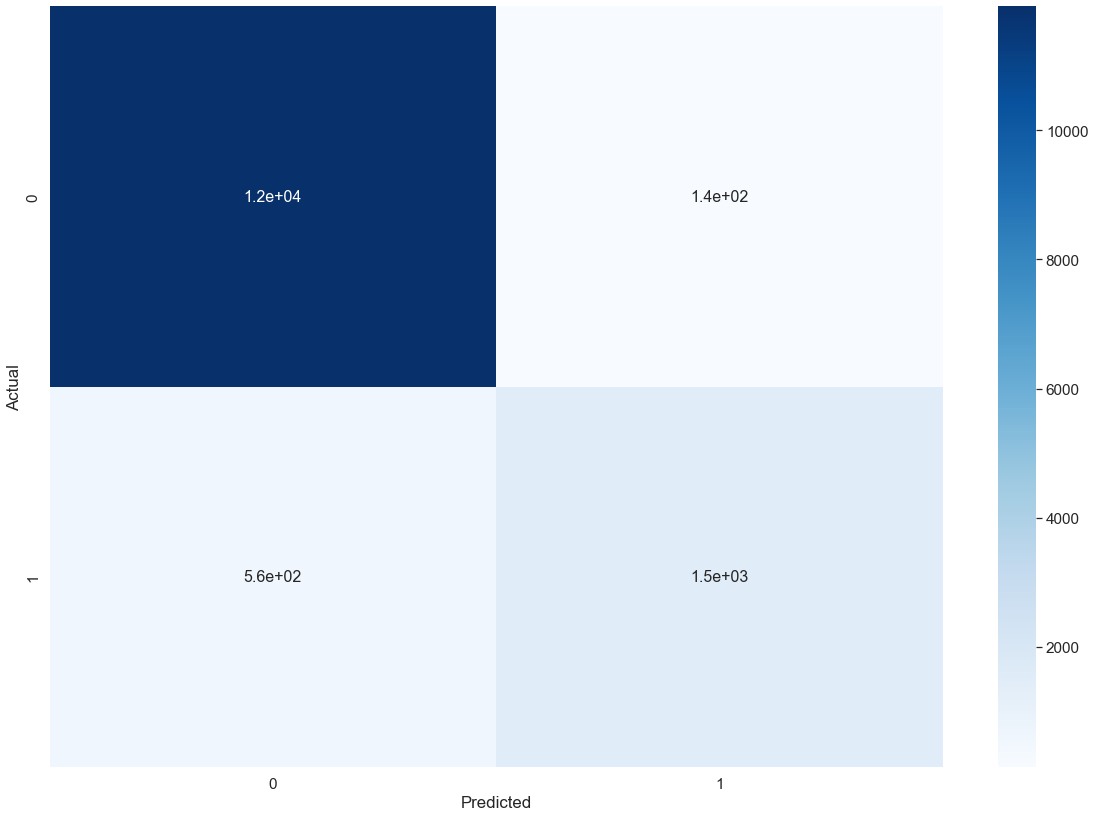

In [ ]:
df_cm = pd.DataFrame(cm, columns=np.unique(list(class_names)), index=np.unique(list(class_names)))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize=(20, 14))
sn.set(font_scale=1.4)  # for label size
sn.heatmap(df_cm, cmap="Blues", annot=True, annot_kws={"size": 16})


In [ ]:
model = keras.models.load_model('E:/archive ee(1)/DN121.h5')